In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime

# This code is derived from AWS SageMaker Samples:
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_electricity
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_synthetic

<h2>DeepAR - Kaggle Bike Sharing Demand Dataset</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>

<h4>To download original dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
None of these features are used: ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']<br>
       
Start Time From: ['datetime'] <br>
Target Feature: [<b>'count','registered','casual'</b>]<br>
Frequency: 'Hourly' <br>

Objective: <quote>You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)</quote>

In [2]:
target_values = ['count','registered','casual']

# controls if categories (in this case we are using it to indicate one of the above rentals) needs to be
# included in the training and test data
with_categories = False

# Set datetime column as index to work with data based on Date/Time
df = pd.read_csv('train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)

In [3]:
# Minimum time and Maximum Time in Training CSV file
df.index.min(),df.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [4]:
# Minimum time and Maximum Time in test CSV file
df_test.index.min(),df_test.index.max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2012-12-31 23:00:00'))

In [5]:
df_test.head(25)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012


/tmp/ipykernel_14225/3942183718.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2011-01']['count'].plot()


<AxesSubplot: xlabel='datetime'>

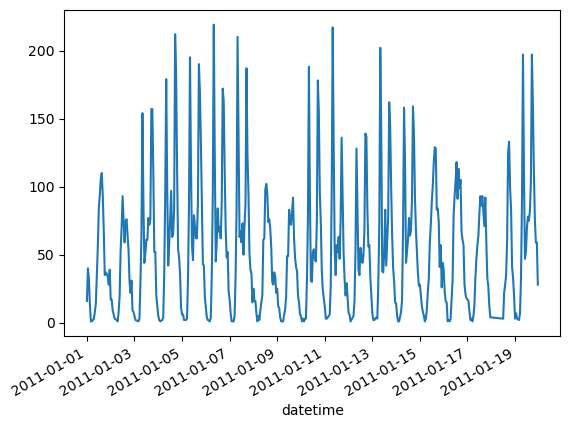

In [6]:
df['2011-01']['count'].plot()

In [8]:
# We need to let DeepAR know how far in the future predictions can be made using prediction_length hyperparameter
# Let's look at how many hours we need to predict in a month using test.csv data file
hours_to_predict = []
print ('Check maximum hours we need to predict')
# Group by year,month
predict_window = df_test.groupby([df_test.index.year,df_test.index.month])
for i,x in predict_window:
    delta = x.index.max() - x.index.min() 
    hours = np.ceil(delta.total_seconds()/3600)
    hours_to_predict.append(hours)
    print ("{0}, Hours:{1}".format(i, hours))

print ("Maximum Prediction Length in Hours: ", np.max(hours_to_predict))

Check maximum hours we need to predict
(2011, 1), Hours:287.0
(2011, 2), Hours:215.0
(2011, 3), Hours:287.0
(2011, 4), Hours:263.0
(2011, 5), Hours:287.0
(2011, 6), Hours:263.0
(2011, 7), Hours:287.0
(2011, 8), Hours:287.0
(2011, 9), Hours:263.0
(2011, 10), Hours:287.0
(2011, 11), Hours:263.0
(2011, 12), Hours:287.0
(2012, 1), Hours:287.0
(2012, 2), Hours:239.0
(2012, 3), Hours:287.0
(2012, 4), Hours:263.0
(2012, 5), Hours:287.0
(2012, 6), Hours:263.0
(2012, 7), Hours:287.0
(2012, 8), Hours:287.0
(2012, 9), Hours:263.0
(2012, 10), Hours:287.0
(2012, 11), Hours:263.0
(2012, 12), Hours:287.0
Maximum Prediction Length in Hours:  287.0


In [9]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
    
freq='H' # Timeseries consists Hourly Data and we need to predict hourly rental count

# how far in the future predictions can be made
# 12 days worth of hourly forecast 
prediction_length = 288 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 288

In [10]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)

# use for model training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(hours=12*24) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 

/tmp/ipykernel_14225/2911486515.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)
/tmp/ipykernel_14225/2911486515.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
/tmp/ipykernel_14225/2911486515.py:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)


In [11]:
dt_predict_max,dt_predict_max + datetime.timedelta(hours=1)

(Timestamp('2012-12-31 23:00:00', freq='H'),
 Timestamp('2013-01-01 00:00:00', freq='H'))

In [15]:
# Let's see if there are gaps in timesteps
def is_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return not dt_range.equals(df[start:end].index)

def get_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return dt_range.difference(df[start:end].index)    

# List timeseries with only NaNs
# They can be removed
def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            #print (col)
            l.append(col)
    return l

In [16]:
is_missing_steps(df, '2011-01-01 00:00:00', '2011-01-19 23:00:00','H')

True

In [17]:
get_missing_steps(df, '2011-01-01 00:00:00', '2011-01-19 23:00:00','H')

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               '2011-01-12 04:00:00', '2011-01-14 04:00:00',
               '2011-01-18 00:00:00', '2011-01-18 01:00:00',
               '2011-01-18 02:00:00', '2011-01-18 03:00:00',
               '2011-01-18 04:00:00', '2011-01-18 05:00:00',
               '2011-01-18 06:00:00', '2011-01-18 07:00:00',
               '2011-01-18 08:00:00', '2011-01-18 09:00:00',
               '2011-01-18 10:00:00', '2011-01-18 11:00:00',
               '2011-01-19 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [33]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 00:00:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17
2011-01-02 01:00:00,1,0,0,2,18.04,21.970,94,16.9979,1,16,17
2011-01-02 02:00:00,1,0,0,2,17.22,21.210,100,19.0012,1,8,9
2011-01-02 03:00:00,1,0,0,2,18.86,22.725,94,12.9980,2,4,6
2011-01-02 04:00:00,1,0,0,2,18.86,22.725,94,12.9980,2,1,3
2011-01-02 06:00:00,1,0,0,3,17.22,21.210,77,19.9995,0,2,2
2011-01-02 07:00:00,1,0,0,2,16.40,20.455,76,12.9980,0,1,1
2011-01-02 08:00:00,1,0,0,3,16.40,20.455,71,15.0013,0,8,8
2011-01-02 09:00:00,1,0,0,2,15.58,19.695,76,15.0013,1,19,20


<AxesSubplot: xlabel='datetime'>

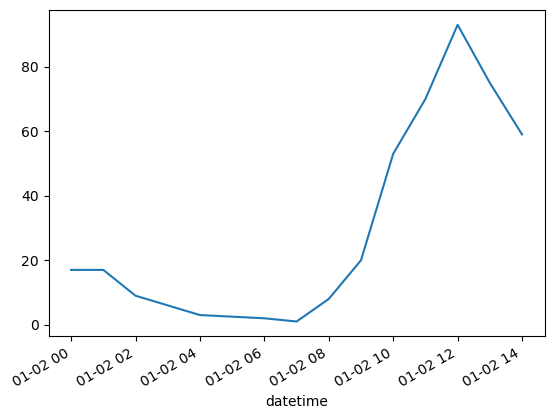

In [18]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']['count'].plot()

In [19]:
df = df.resample('1h').mean()

In [20]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 00:00:00,1.0,0.0,0.0,2.0,18.86,22.725,88.0,19.9995,4.0,13.0,17.0
2011-01-02 01:00:00,1.0,0.0,0.0,2.0,18.04,21.970,94.0,16.9979,1.0,16.0,17.0
2011-01-02 02:00:00,1.0,0.0,0.0,2.0,17.22,21.210,100.0,19.0012,1.0,8.0,9.0
2011-01-02 03:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,4.0,6.0
2011-01-02 04:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,1.0,3.0
2011-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02 06:00:00,1.0,0.0,0.0,3.0,17.22,21.210,77.0,19.9995,0.0,2.0,2.0
2011-01-02 07:00:00,1.0,0.0,0.0,2.0,16.40,20.455,76.0,12.9980,0.0,1.0,1.0
2011-01-02 08:00:00,1.0,0.0,0.0,3.0,16.40,20.455,71.0,15.0013,0.0,8.0,8.0


<AxesSubplot: title={'center': 'Missing values in training data'}, xlabel='datetime'>

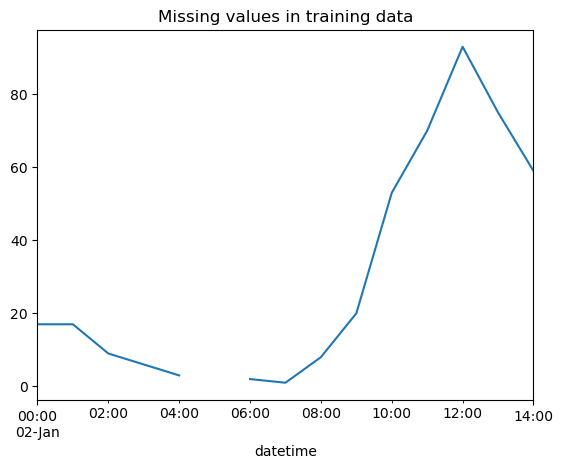

In [21]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']['count'].plot(title='Missing values in training data')

<AxesSubplot: xlabel='datetime'>

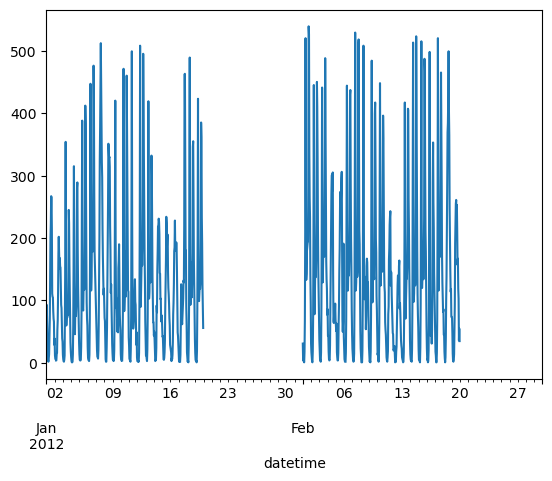

In [22]:
df['2012-01':'2012-02']['count'].plot()

In [23]:
target_values

['count', 'registered', 'casual']

In [24]:
df[dt_test_range[0]:dt_test_range[1]]['count'].tail()

datetime
2012-12-19 19:00:00    336.0
2012-12-19 20:00:00    241.0
2012-12-19 21:00:00    168.0
2012-12-19 22:00:00    129.0
2012-12-19 23:00:00     88.0
Freq: H, Name: count, dtype: float64

In [25]:
dt_test_range

(Timestamp('2011-01-01 00:00:00', freq='H'),
 Timestamp('2012-12-19 23:00:00', freq='H'))

In [26]:
dt_train_range

(Timestamp('2011-01-01 00:00:00', freq='H'),
 Timestamp('2012-12-07 23:00:00', freq='H'))

In [27]:
time_series_test = []
time_series_training = []

for target in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][target])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][target])

In [28]:
time_series_test[0][:5],time_series_test[1][:5],time_series_test[2][:5]

(datetime
 2011-01-01 00:00:00    16.0
 2011-01-01 01:00:00    40.0
 2011-01-01 02:00:00    32.0
 2011-01-01 03:00:00    13.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: count, dtype: float64,
 datetime
 2011-01-01 00:00:00    13.0
 2011-01-01 01:00:00    32.0
 2011-01-01 02:00:00    27.0
 2011-01-01 03:00:00    10.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: registered, dtype: float64,
 datetime
 2011-01-01 00:00:00    3.0
 2011-01-01 01:00:00    8.0
 2011-01-01 02:00:00    5.0
 2011-01-01 03:00:00    3.0
 2011-01-01 04:00:00    0.0
 Freq: H, Name: casual, dtype: float64)

In [29]:
time_series_training[0][:5],time_series_training[1][:5],time_series_training[2][:5]

(datetime
 2011-01-01 00:00:00    16.0
 2011-01-01 01:00:00    40.0
 2011-01-01 02:00:00    32.0
 2011-01-01 03:00:00    13.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: count, dtype: float64,
 datetime
 2011-01-01 00:00:00    13.0
 2011-01-01 01:00:00    32.0
 2011-01-01 02:00:00    27.0
 2011-01-01 03:00:00    10.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: registered, dtype: float64,
 datetime
 2011-01-01 00:00:00    3.0
 2011-01-01 01:00:00    8.0
 2011-01-01 02:00:00    5.0
 2011-01-01 03:00:00    3.0
 2011-01-01 04:00:00    0.0
 Freq: H, Name: casual, dtype: float64)

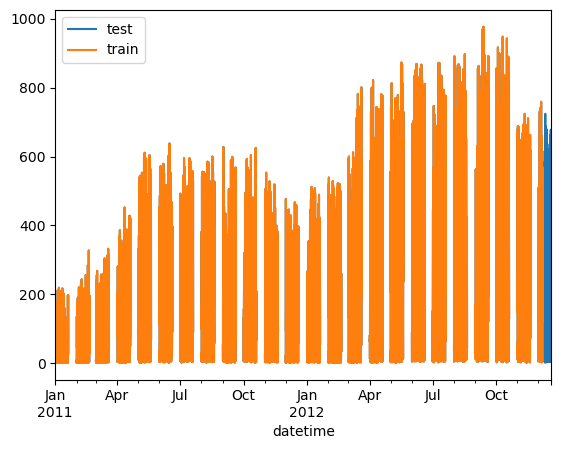

In [30]:
time_series_test[0].plot(label='test')
time_series_training[0].plot(label='train')#, ls=':')
plt.legend()
plt.show()

In [31]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [32]:
list(time_series_training[0][:5])

[16.0, 40.0, 32.0, 13.0, 1.0]

In [33]:
series_to_obj(time_series_training[0][:5],[0] if with_categories else None)

{'start': '2011-01-01 00:00:00', 'target': [16.0, 40.0, 32.0, 13.0, 1.0]}

In [34]:
series_to_jsonline(time_series_training[0][:5],[0] if with_categories else None)

'{"start": "2011-01-01 00:00:00", "target": [16.0, 40.0, 32.0, 13.0, 1.0]}'

In [35]:
encoding = "utf-8"
cat_idx = 0

train_file_name = "train.json"
test_file_name = "test.json"

if with_categories:
    train_file_name = "train_with_categories.json"
    test_file_name = "test_with_categories.json"

with open(train_file_name, 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [36]:
cat_idx = 0
with open(test_file_name, 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [37]:
df.to_csv('all_data.csv',index=True,index_label='datetime')

In [38]:
for ts in time_series_test:
    print (len(ts),ts.name)

17256 count
17256 registered
17256 casual


In [39]:
for ts in time_series_training:
    print (len(ts),ts.name)

16968 count
16968 registered
16968 casual
